In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from models.vgg import VGG
from gsp_methods import *
import statistics


import math
import sys 
sys.path.append('/data/users2/rohib/github/testing')
import utils_gsp.sps_tools as sps_tools
import utils_gsp.padded_gsp as gsp_pad

from torch.utils.tensorboard import SummaryWriter

In [3]:
class Args:
    lr = 0.1
    resume = False
    gsp_sps = 0.8
    gsp_int = 3
    start_epoch = -1

args = Args

writer = SummaryWriter()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Model
print('==> Building model..')
# net = VGG(depth=16, dataset='cifar10', batchnorm=True)
model = VGG('VGG19')
model = model.to(device)
model.gsp_training_mode = False
# model

==> Building model..


In [6]:
def get_model_layers(model):
    names = list()
    weight_l = list()
    shape_l = list()
    weight_d = dict()
    layers = dict()
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            weight_d[name] = layer.weight
            weight_l.append(layer.weight)
            shape_l.append(layer.weight.shape)
            layers[name] = layer
            names.append(name)
            
    return names, weight_l, shape_l, weight_d, layers

best_acc
def gsp_sparse_training(model, args):
    # Additional Class Variables for GSP
    print(f"ARGS GSP INT: {args.gsp_int}")
    model.sps = args.gsp_sps
    model.curr_iter = 0
    model.start_gsp_epoch = -1
    model.gsp_int = args.gsp_int
    model.logger = None
    model.gsp_training_mode = True

    if args.resume:
        model.curr_epoch = args.start_epoch
        print(f"Current Epoch: {args.start_epoch}")
    else:
        model.curr_epoch = 0

gsp_sparse_training(model, args)

ARGS GSP INT: 3


In [7]:
names, weight_l, shape_l, weight_d, layers = get_model_layers(model)

In [8]:
bind_new_gsp_methods_to_model(model, args)

Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding the NEW forward layers!
Binding 

In [9]:
chk_name = 'gsp_gates_1'
args.resume = True
if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./checkpoint/{chk_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Resuming from checkpoint..


In [ ]:
model.gsp_training_mode = True
model.start_gsp_epoch = -1

print(f"gsp start epoch: {model.start_gsp_epoch}")
print(f"epoch: {model.curr_epoch} | iter: {model.curr_iter} | gsp_int: {model.gsp_int}")

images, target = next(iter(trainloader))

images = images.cuda('cuda:0', non_blocking=True)
target = target.cuda('cuda:0', non_blocking=True)

optimizer.zero_grad()
output = model(images)
loss = criterion(output, target)

model.curr_iter += 1
# get_abs_sps(model)

In [ ]:
loss.backward()
optimizer.step()

In [10]:
def get_gates(model):
    gates_l = list()
    gate_cat = np.array([])
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            data = layer.gsp_gate.detach().clone().flatten().cpu().numpy()
            # gates_l.append(data)
            gate_cat = np.concatenate((gate_cat, data))
    return gates_l, gate_cat

In [11]:
gates_l, gate_cat = get_gates(model)

gmax = gate_cat.max()
gmin = gate_cat.min()

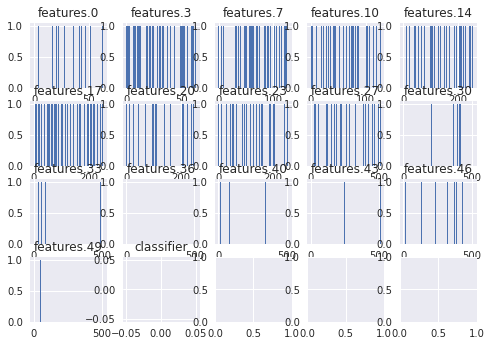

In [41]:
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=4, ncols=5)

shapes_l = list()
gates_l = list()
gates_norm = list()
gate_cat = np.array([])
gate_cat_torch = torch.tensor([]).cuda()


count = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):

        # data = np.abs(layer.gsp_gate.detach().clone().flatten().cpu().numpy())
        data_torch = torch.abs(layer.gsp_gate.detach().clone().flatten())
        # data = data_torch.cpu().numpy()

        shapes_l.append(data_torch.shape[0])
        dmin = data_torch.min(); dmax= data_torch.max()
        data_torch -= dmin
        data_torch /= (dmax - dmin)

        data = data_torch.cpu().numpy()
        gates_l.append(data)
        gates_norm.append(data)

        # gate_cat = np.concatenate((gate_cat, data))
        # if 'classifier' not in name:
        gate_cat_torch = torch.cat( (gate_cat_torch, data_torch) )

        x_vals = list(range(data.shape[0]))
        ax.reshape(-1)[count].bar( x_vals , data)
        ax.reshape(-1)[count].set_title(name)
        count += 1

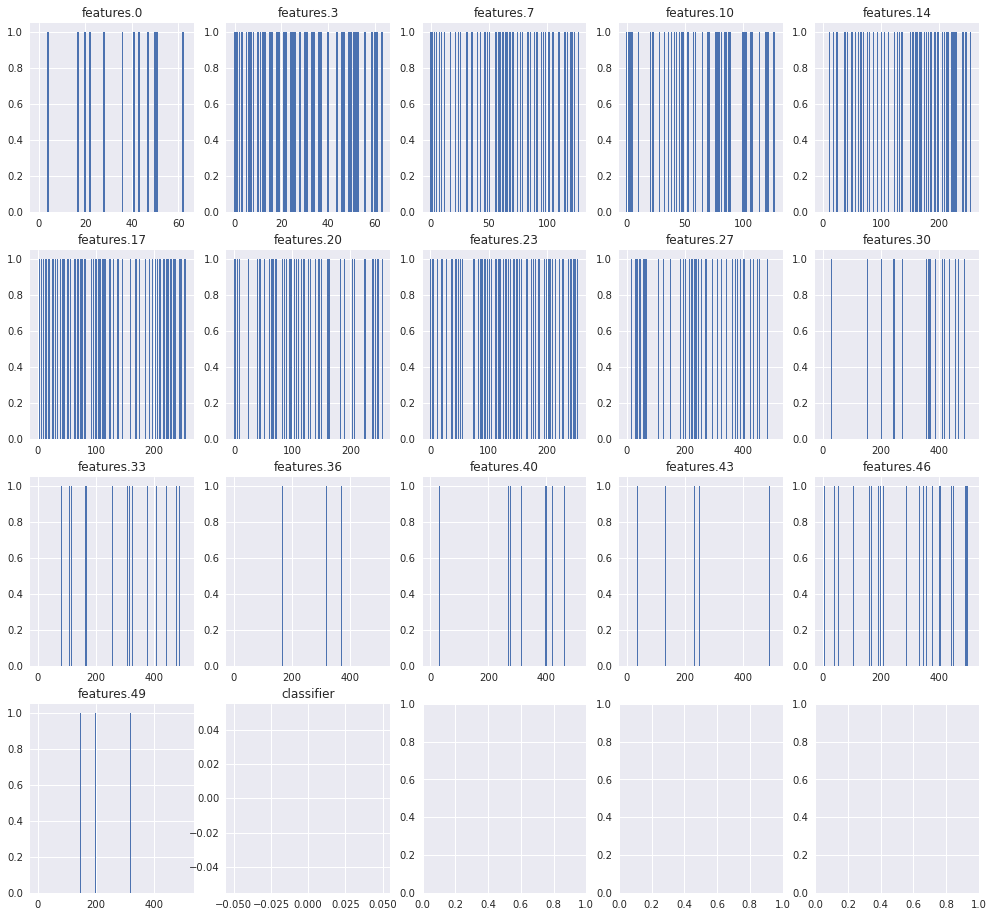

In [42]:
# fig.set_size_inches(18, 16)
fig.set_size_inches(17, 16)
fig

In [44]:
total = gate_cat_torch.numel()
nonzero = torch.nonzero(gate_cat_torch).numel()
(total-nonzero)/total

0.7999637286906057

In [45]:
gate_cat_torch.numel()

5514

In [20]:
def keep_topk( gate_cat_torch, prune_sps=0.8):
    mask_gate_cat = torch.zeros_like(gate_cat_torch, device=gate_cat_torch.device)
    k = math.floor(gate_cat_torch.shape[0] * (1 - prune_sps))
    # print(k)
    vals, ind = torch.topk(gate_cat_torch, k=k)
    mask_gate_cat[ind] = torch.ones_like(vals, device=vals.device)
    # mask_gate_cat[ind] = vals
    return mask_gate_cat

mask_gate_cat = keep_topk(gate_cat_torch)

In [26]:
def get_masked_gate_list(shapes_l, names):
    masked_gate_d = dict()
    start = 0
    for i, shape in enumerate(shapes_l):
        masked_gate_d[names[i]] = mask_gate_cat[ start:(start+shape)]
        start += shape
        # print(start)
    return masked_gate_d

In [27]:
masked_gate_d = get_masked_gate_list(shapes_l, names)

# [x.shape for x in masked_gate_d.values()]

In [38]:
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        mask_gates = masked_gate_d[name].reshape(layer.gsp_gate.shape)
        
        if isinstance(layer, nn.Conv2d):
            assert (layer.gsp_gate.shape == mask_gates.shape), "Shape Mismatch in masked gate re-insertion"
            layer.gsp_gate.data = masked_gate_d[name].reshape(layer.gsp_gate.shape)
            layer.gsp_gate.requires_grad = False
        if isinstance(layer, nn.Linear):
            assert (layer.gsp_gate.shape == mask_gates.shape), "Shape Mismatch in masked gate re-insertion"
            layer.gsp_gate.data = torch.ones_like(layer.gsp_gate, device=layer.gsp_gate.device)
            layer.gsp_gate.requires_grad = False

In [ ]:
# STANDARAD DEVIATION
tensor = np.abs(gates_l[13])
threshold = np.std(tensor)*0
new_mask = np.where(abs(tensor) < threshold, 0, tensor)
x_values = list(range(tensor.shape[0]))
print(np.std(tensor))
# plt.bar(x_values , new_mask)
plt.bar(x_values , tensor)


In [ ]:
# Filters to Keep
layer_sps = 0.8
num_keep_filter = int(np.ceil(tensor.shape[0] * (1-layer_sps)))
print(num_keep_filter)

# Get TopK and create vector with topk values and zeros rest
ind = np.argpartition(tensor, -num_keep_filter)[-num_keep_filter:]
mask_tensor = np.zeros_like(tensor)

In [ ]:
mask_tensor[ind] = tensor[ind]
plt.bar(x_values , mask_tensor)

In [ ]:
# for i, data in enumerate(gates_l):
#     x_vals = list(range(data.shape[0]))
#     plt.bar( x_vals , data)
#     break

In [ ]:
# data.max()
# data.min()
print(data.shape)
bins = np.linspace(-data.max(), data.max(), data.shape[0])

In [ ]:
# # plt.hist(data, bins)
# fig1, ax1 = plt.subplots(nrows=4, ncols=5)

# gates_l = list()
# plt.style.use('seaborn')
# count = 0
# for name, layer in model.named_modules():
#     if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
#         # gates_l.append(layer.gsp_gate.detach().clone().flatten().cpu().numpy())
#         data = layer.gsp_gate.detach().clone().flatten().cpu().numpy()
#         data -= data.min()
#         data /= (data.max() - data.min())

#         x_vals = list(range(data.shape[0]))
#         bin_len = int(data.shape[0]//4.)
#         bins = np.linspace(-data.max(), data.max(), bin_len)

#         ax1.reshape(-1)[count].hist(data, bins)
#         count += 1

In [ ]:
# fig1.set_size_inches(12, 8)
# fig1

In [ ]:
plt.style.use('seaborn')
data = np.abs(layers[names[1]].gsp_gate.detach().clone().flatten().cpu().numpy())
x_vals = data.shape[0]
# sns.barplot(data=data)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(list(range(x_vals)), data)


In [ ]:
# list(range(x_vals))

In [ ]:
sps_tools.sparsity(layers[names[9]].gsp_gate.flatten())

In [ ]:
gate_d = model.gate_d
matrix, ni_list = gsp_pad.pad_input_dict(gate_d)
len(gate_d)

In [ ]:
# gate_d[15][0:ni_list[15]]

In [ ]:
cnt = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        trimmed_gate = gate_d[cnt][0:ni_list[cnt]]
        layer.gsp_gate.data = trimmed_gate
        # print(trimmed_gate.shape)
        cnt += 1

In [ ]:
layer.gsp_gate

In [ ]:
print(sps_tools.padded_sparsity(matrix, ni_list))

In [ ]:
xp_mat, ni_list = gsp_pad.groupedsparseproj(gate_d, 0.85, precision=1e-6, linrat=0.9)

In [ ]:
gsp_gate

In [ ]:
sps_tools.padded_sparsity(xp_mat, ni_list)

------------------
## Flow Through Network

In [ ]:
images, target = next(iter(trainloader))

images = images.cuda('cuda:0', non_blocking=True)
target = target.cuda('cuda:0', non_blocking=True)
print(images.shape)

In [ ]:
# model.features(images)
out1 = model.features[0](images)
print(f"images: {images.shape} || layer1: {model.features[0].weight.shape } || out: {out1.shape}")

out2 = model.features[3](out1)
print(f"inputs: {out1.shape} || layer2: {model.features[3].weight.shape} || out: {out2.shape}")

out3 = model.features[7](out2)
print(f"inputs: {out2.shape} || layer3: {model.features[7].weight.shape} || out: {out3.shape}")

out4 = model.features[10](out3)
print(f"inputs: {out3.shape} || layer4: {model.features[10].weight.shape} || out: {out4.shape}")

out5 = model.features[14](out4)
print(f"inputs: {out4.shape} || layer5: {model.features[14].weight.shape} || out: {out5.shape}")

In [ ]:
model.features[14].weight.shape

In [ ]:
# images, target = next(iter(trainloader))

# images = images.cuda('cuda:0', non_blocking=True)
# target = target.cuda('cuda:0', non_blocking=True)
# print(images.shape)

# model(images)

In [ ]:
a = torch.ones(2,2,4,2)
print(a)
b = torch.ones(2,2,2,1) * 2

In [ ]:
print(a @ b)

-------------
## Setup Training and related functions

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print( f"[{batch_idx}/{len(trainloader)}], Loss: {(train_loss/(batch_idx+1))} | Acc: {100.*correct/total} " \
                   f"grad norm-7: {torch.norm(model.features[7].gsp_gate.grad):.3f} | w_norm: {torch.norm(model.features[7].gsp_gate):.3f}")

In [ ]:
model.gsp_training_mode = False
def test(model, criterion, testloader, epoch, args):
    global best_acc
    model.eval()
    model.gsp_training_mode = False

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    print(f"Accuracy: {acc}")

test(model, criterion, testloader, 1, args)

In [ ]:
train(2)

In [ ]:
def get_topk_gates(model, prune_sps=0.8):
    pruned_gates = dict()

    for name, param in model.named_parameters():
        if 'gsp_gate' in name:
            gate_vec = param.detach()
            k = math.floor(gate_vec.shape[0] * (1-prune_sps))
            val, ind = torch.topk(gate_vec, k=k)

            pruned_gates[name] = torch.zeros_like(gate_vec)
            pruned_gates[name][ind] = val

            pruned_gates[name] -= pruned_gates[name].min()
            pruned_gates[name] /= pruned_gates[name].max()
    # [x.shape for x in gates.values()]
    return pruned_gates

In [ ]:
def get_topk_act(model, prune_sps=0.8):
    pruned_gates = dict()
    pruned_gates_l = list()

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            gate_vec = layer.reshaped_act.detach().flatten()
            k = math.floor(gate_vec.shape[0] * (1-prune_sps))
            val, ind = torch.topk(gate_vec, k=k)

            pruned_gates[name] = torch.zeros_like(gate_vec)
            pruned_gates[name][ind] = val

            pruned_gates[name] -= pruned_gates[name].min()
            pruned_gates[name] /= pruned_gates[name].max()
            pruned_gates_l.append(pruned_gates[name])
    # [x.shape for x in gates.values()]
    return pruned_gates, pruned_gates_l

In [ ]:
pruned_gates, pruned_gates_l = get_topk_act(model)
pruned_gates = get_topk_gates(model)
# [x.shape for x in pruned_gates.values()]

In [ ]:
def get_abs_sps(model):
    nonzero = total = 0
    # print(f"TYPE: {type(model)}")

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            # print(name)
            tensor = layer.weight.detach().clone()
            # nz_count.append(torch.count_nonzero(tensor))
            nz_count = torch.count_nonzero(tensor).item()
            total_params = tensor.numel()
            nonzero += nz_count
            total += total_params
    
    # print(f"TOTAL: {total}")
    abs_sps = 100 * (total-nonzero) / total

    return abs_sps, total, (total-nonzero)

In [ ]:
# layer_d = dict()
def prune_filters(model):
    prod_l = list()
    act_mat_d = dict()
    prune_sps = 0.80

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            # layer_d[name] = layer
            prod = torch.abs(layer.gsp_w @ layer.gsp_gate)
            # Normalize
            prod -= prod.min()
            prod /= prod.max()
            # print(f" gsp_w: {layer.gsp_w.shape} | gate: {layer.gsp_gate.shape} | prod: {prod.shape}")
            prod_l.append(prod)
            
            # Get TopK and create vector with topk values and zeros rest
            act_mat = torch.zeros_like(prod)
            k = math.floor(prod.shape[0] * (1 - prune_sps))
            vals, ind = torch.topk(prod, k=k)
            act_mat[ind] = vals

            if isinstance(layer, nn.Conv2d): 
                reshaped_act = act_mat.reshape(act_mat.shape[0],1,1,1)
                layer.weight.data = layer.weight.data * reshaped_act
            if isinstance(layer, nn.Linear):
                reshaped_act = act_mat.reshape(act_mat.shape[0],1)
                layer.weight.data = layer.weight.data * reshaped_act
            print(f"LayerShp: {layer.weight.shape} | prod: {prod.shape} | act_mat: {reshaped_act.shape}")
            # print(f"Layer Data Shape: {}")
            act_mat_d[name] = act_mat

In [ ]:
for name, layer in model.named_parameters():
    print(name)

In [ ]:
setup_pruning_exp(model, prune_sps = 0.9)

In [ ]:
for name, layer in model.named_parameters():
    print(name)

In [ ]:
prune_filters(model)
get_abs_sps(model)

In [ ]:
masks_d, masks_l = sps_tools.get_conv_linear_mask(model)

In [ ]:
apply_prune_mask(model, masks_l)

-----------
-----------

## Pass Minibatch to test GSP

In [ ]:
model.gsp_training_mode = True
model.start_gsp_epoch = -1

print(f"gsp start epoch: {model.start_gsp_epoch}")
print(f"epoch: {model.curr_epoch} | iter: {model.curr_iter} | gsp_int: {model.gsp_int}")

images, target = next(iter(trainloader))

images = images.cuda('cuda:0', non_blocking=True)
target = target.cuda('cuda:0', non_blocking=True)

optimizer.zero_grad()
output = model(images)
loss = criterion(output, target)

model.curr_iter += 1
get_abs_sps(model)

In [ ]:
# print(model.features[0].weight.grad)
# print(torch.norm(model.features[7].gsp_gate.grad))

In [ ]:
loss.backward()
optimizer.step()

get_abs_sps(model)

In [ ]:
print(torch.norm(model.features[7].gsp_gate.grad))
print(torch.norm(model.features[7].gsp_gate))

In [ ]:
# sps_tools.get_layerwise_sps(net)
# sps_tools.get_abs_sps(net)a

images, target = next(iter(trainloader))
images = images.cuda('cuda:0', non_blocking=True)
target = target.cuda('cuda:0', non_blocking=True)

# writer.add_graph(model, images)